In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, UpSampling2D, Cropping2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import PIL
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [3]:
class UNet:    
    def __init__(self, img_dim=None):
        self.img_shape = (img_dim, img_dim, 3)
    
    def Conv2D_x2_Pool(self, x, filters, pool=True):
        conv = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
        res = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(conv)
        if pool:
            out = MaxPooling2D()(res)
            return out, res
        else:
            return res
    
    def UpConv(self, x, res, filters):
        x = UpSampling2D()(x)
        conv = Conv2D(filters=filters, kernel_size=(2,2), padding='same')(x)
        cropping_size = res.get_shape().as_list()[1] - conv.get_shape().as_list()[1]
        crop = Cropping2D(cropping=cropping_size//2)(res)
        merged = Concatenate()([conv, crop])
        conv_op_1 = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(merged)
        out = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(conv_op_1)    
        return out
    
    def create_model(self):
        img = Input(shape=self.img_shape)
        filters = [64, 128, 256, 512, 1024]

        x = img
        residuals = []
        pool = True

        for fil in filters:

            if fil == 1024:
                pool = False

            if pool == True: 
                x, res = self.Conv2D_x2_Pool(x, fil, pool=pool)
                residuals.append(res)

            else:
                x = self.Conv2D_x2_Pool(x, fil, pool=pool)
        
        counter = -1
        
        for fil in reversed(filters[:-1]):

            x = self.UpConv(x, residuals[counter], fil) 
            
            counter = counter - 1
            
        out = Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
        
        model = Model(inputs=img, outputs=out)
        
        return model

In [4]:
# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [5]:
seed = 1
DATA_DIR = 'Brestcancer/'

In [6]:
def dice_coef(y_true, y_pred):
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    isct = tf.reduce_sum(y_true * y_pred)
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [7]:
img_size = 256
nbatchsize=8
image_args = dict(seed=seed,
    batch_size=nbatchsize,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=nbatchsize,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

DIR = 'Brestcancer/'
images = 'images/'
masks = 'masks/'

# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow_from_directory(**image_args, directory="Brestcancer"),  
                      mask_datagen.flow_from_directory(**mask_args, directory="Brestcancer"))

validation_generator = zip(image_datagen.flow_from_directory(**image_args, directory="Brestcancer"),  
                      mask_datagen.flow_from_directory(**mask_args, directory="Brestcancer"))

Found 908 images belonging to 2 classes.
Found 908 images belonging to 2 classes.
Found 908 images belonging to 2 classes.
Found 908 images belonging to 2 classes.


In [8]:
img1, mask1 = next(train_generator)

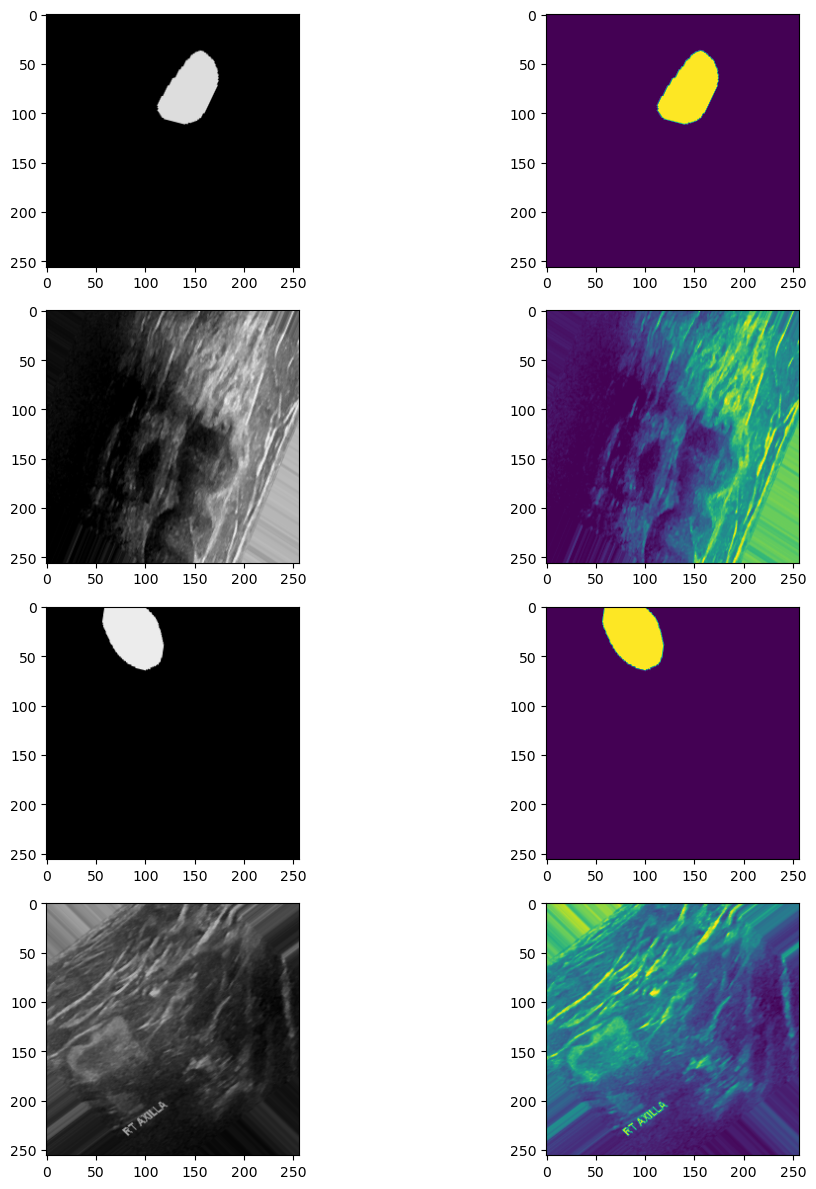

In [9]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

In [10]:
net = UNet(img_dim=img_size)
model = net.create_model()

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='./logs/logs_1e-4')]

2023-02-22 22:02:40.644180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-22 22:02:40.644244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-02-22 22:02:40.669657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
nepochs=5
hist=model.fit_generator(train_generator, steps_per_epoch=135, epochs=nepochs, validation_data=validation_generator,
        validation_steps=16, callbacks=callbacks, workers=2)

Epoch 1/5
135/135 [==============================] - 3954s 29s/step - loss: 0.3505 - dice_coef: 0.4713 - val_loss: 0.5512 - val_dice_coef: 0.3646 - lr: 1.0000e-04
Epoch 2/5
 12/135 [=>............................] - ETA: 49:39 - loss: 0.2828 - dice_coef: 0.7018

KeyboardInterrupt: 

In [12]:
net = UNet(img_dim=img_size)
model = net.create_model()
filename = 'weights/best_weights.hdf5'
model.load_weights(filename)

1/1 [==============================] - 0s 473ms/step


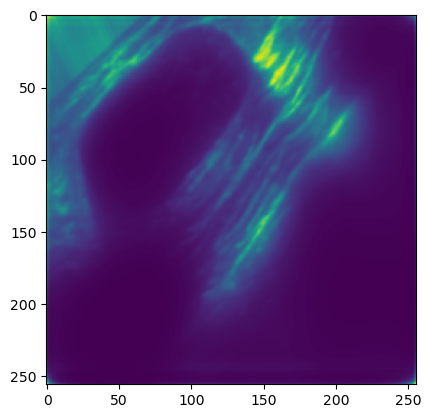

In [14]:
img, mask = next(train_generator)
mask_test = model.predict(img[0][np.newaxis, :])
plt.imshow(mask_test[0,:,:,0])


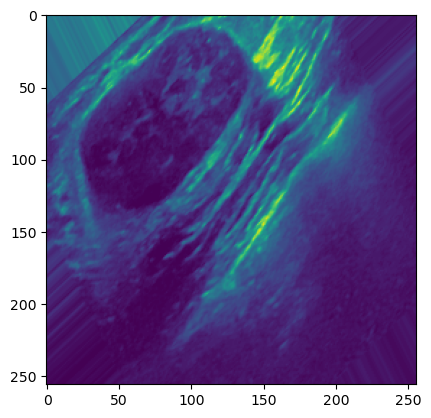

In [15]:
plt.imshow(mask[0,:,:,0])


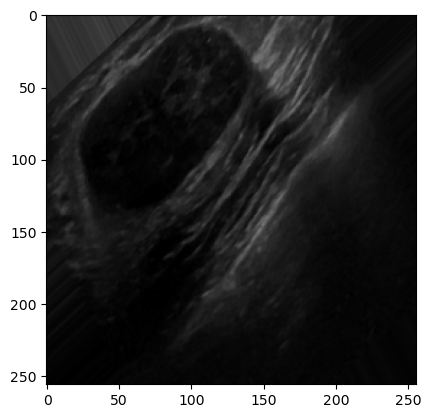

In [16]:
plt.imshow(img[0])

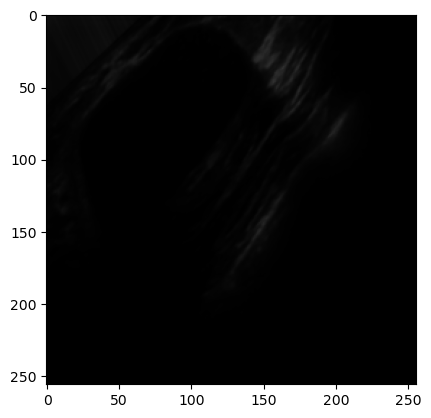

In [24]:
plt.imshow(img[0]*mask_test[0,:,:,:])

In [21]:
plt.figure(figsize=(60, 30))
#plt.plot(model.history.history['loss'], linewidth=8, color='r')                 
plt.plot(model.history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()

KeyError: 'val_loss'

<Figure size 6000x3000 with 0 Axes>